In [1]:
%reload_ext autoreload
%autoreload 1
import joblib
from ray import tune, train
import copy
import shap
import matplotlib.pyplot as plt
import polars as pl
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
from functions.transformers import PolarsColumnTransformer as PCT
import functions.data_cleaning as dmf
import functions.plot_functions as pf
import functions.tuning as tunes
import functions.feature_engineering as feats
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report,f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from IPython.display import display,Markdown
import lightgbm as lgb
%aimport functions.tuning
%aimport functions.transformers
%aimport functions.data_cleaning
%aimport functions.plot_functions
%aimport functions.feature_engineering

In [2]:
data_train_single=pl.read_parquet('data/data_accepted_single_train.parquet')
data_val_single=pl.read_parquet('data/data_accepted_single_val.parquet')
data_train_joint=pl.read_parquet('data/data_accepted_joint_train.parquet')
data_val_joint=pl.read_parquet('data/data_accepted_joint_val.parquet')

In [3]:
data_train_single=dmf.clean_accepted_single(data_train_single)
data_val_single=dmf.clean_accepted_single(data_val_single)
data_train_joint=dmf.clean_accepted_joint(data_train_joint)
data_val_joint=dmf.clean_accepted_joint(data_val_joint)

##### Dropping Features:

In [4]:
data_train_single=dmf.remove_poor_features_single(data_train_single)
data_val_single=dmf.remove_poor_features_single(data_val_single)
data_train_joint=dmf.remove_poor_features_joint(data_train_joint)
data_val_joint=dmf.remove_poor_features_joint(data_val_joint)

### Feature Engineering

In [5]:
data_train_single=feats.date_features(data_train_single,'issue_d')
data_val_single=feats.date_features(data_val_single,'issue_d')
data_train_joint=feats.date_features(data_train_joint,'issue_d')
data_val_joint=feats.date_features(data_val_joint,'issue_d')

In [6]:
data_train_single=dmf.label_target_grades(data_train_single,)
data_val_single=dmf.label_target_grades(data_val_single,)
data_train_joint=dmf.label_target_grades(data_train_joint,)
data_val_joint=dmf.label_target_grades(data_val_joint,)

In [7]:
X_train_single=data_train_single.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_train_single=data_train_single['grade']

X_val_single=data_val_single.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_val_single=data_val_single['grade']

X_train_joint=data_train_joint.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_train_joint=data_train_joint['grade']

X_val_joint=data_val_joint.drop(columns=['grade','sub_grade','int_rate','issue_d'])
y_val_joint=data_val_joint['grade']


#### Imputers

In [8]:
preprocess_single=Pipeline([])

In [9]:
emp_title_imp = tr.NotInImputerPolars(cat_no=20, fill_value="other")
emp_length_imp = tr.NotInImputerPolars(cat_no=12, fill_value=None)
zip_imp = tr.NotInImputerPolars(cat_no=12, fill_value='other')
imputers = PCT(
    [
        PCT.Step("emp_title", emp_title_imp, "emp_title"),
        PCT.Step("emp_length", emp_length_imp, "emp_length"),
        PCT.Step("zip_code", zip_imp,'zip_code')
    ]
)
preprocess_single.steps.append(("imputers",imputers))

### Encoders

In [10]:
emp_t_enc = tr.TargetMeanOrderedLabeler(how="label")
emp_l_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]
emp_l_enc = tr.PolarsOrdinalEncoder(order=emp_l_order)
home_enc = tr.TargetMeanOrderedLabeler(how="label")
verif_enc = tr.TargetMeanOrderedLabeler(how="label")
paymnt_enc = tr.PolarsOneHotEncoder(drop=True)
purpose_enc = tr.TargetMeanOrderedLabeler(how="label")
zip_enc = tr.TargetMeanOrderedLabeler(how="label")
state_enc = tr.TargetMeanOrderedLabeler(how="label")
init_stat_enc = tr.PolarsOneHotEncoder(drop=True)
disbursement_enc = tr.PolarsOneHotEncoder(drop=True)

encoders = PCT(
    [
        PCT.Step("emp_t_enc", emp_t_enc, "emp_title"),
        PCT.Step("emp_l_enc", emp_l_enc, "emp_length"),
        PCT.Step("home_enc", home_enc, "home_ownership"),
        PCT.Step("verif_enc", verif_enc, "verification_status"),
        PCT.Step("paymnt_enc", paymnt_enc, "pymnt_plan"),
        PCT.Step("purpose_enc", purpose_enc, "purpose"),
        PCT.Step("zip_enc", zip_enc, "zip_code"),
        PCT.Step("state_enc", state_enc, "addr_state"),
        PCT.Step("init_stat_enc", init_stat_enc, "initial_list_status"),
        PCT.Step("disbursement_enc", disbursement_enc, "disbursement_method"),
    ]
)

preprocess_single.steps.append(("encoders",encoders))
null_imp = tr.PolarsNullImputer(fill_value=-9)
preprocess_single.steps.append(("null_imputer",null_imp))

In [11]:
model_single_lgbm = lgb.LGBMClassifier(
    objective="multiclass",
    class_weight="balanced",
    verbose=-1,
    force_col_wise=True,
    random_state=1,
    num_threads=6
)

##### Getting an space of sets of columns to drop:

In [12]:
# original_columns=preprocess_single.fit_transform(X_train_single.sample(10000,seed=1),y_train_single.sample(10000,seed=1)).columns

# boruta_selected_cols={}

# transformed_sample_X = preprocess_single.fit_transform(
#         X_train_single.sample(50000, seed=1), y_train_single.sample(50000, seed=1)
#     )
# transformed_sample_y=y_train_single.sample(50000, seed=1)
# for perc in np.arange(stop=101,start=10,step=10):
#     boruta = tr.BorutaFeatureSelectorPolars(model_single_lgbm, random_state=1, perc=perc)
        
#     boruta.fit(
#         transformed_sample_X,
#         transformed_sample_y,
#     )
#     boruta_selected_cols[perc]=boruta.transform(preprocess_single.fit_transform(
#         X_train_single.sample(10000, seed=1), y_train_single.sample(10000, seed=1)
#     )).columns
#     print(f"{perc} calculated")

# # Setting the number of threads to 1 to avoid parallelization clash with ray tune.
# model_single_lgbm = lgb.LGBMClassifier(
#     objective="multiclass",
#     class_weight="balanced",
#     verbose=-1,
#     force_col_wise=True,
#     random_state=1,
#     num_threads=1
# )

KeyboardInterrupt: 

In [13]:
# cols_to_drop_space=[]
# for key, columns in boruta_selected_cols.items():
#     cols_to_drop_space.append([col for col in original_columns if col not in columns])
# cols_to_drop_space.insert(0,[])
# joblib.dump(cols_to_drop_space,'temp/cols_to_drop.joblib')
cols_to_drop_space=joblib.load('temp/cols_to_drop.joblib')

##### Dropper

In [14]:
feature_dropper = tr.FeatureRemover([])
preprocess_single.steps.append(('feature_dropper',feature_dropper))
full_pipeline_single = Pipeline(
    [("preprocess", preprocess_single), ("model", model_single_lgbm)]
)

##### Baseline for tuning:

In [15]:
full_pipeline_single.fit(X_train_single.sample(100000,seed=1),y_train_single.sample(100000,seed=1))
preds=full_pipeline_single.predict(X_val_single)
print(f1_score(y_val_single,preds,average='macro'))

0.5700060410300853


### Search space

In [16]:
models = tunes.Models()
search_space_lgbm = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__num_leaves": tune.randint(10, 251),
    "model__n_estimators": tune.randint(10, 251),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__bagging_freq": tune.randint(0, 11),
    "model__colsample_bytree": tune.uniform(0.2, 1.0),
    "model__subsample": tune.uniform(0.2, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 100),
    "model__reg_lambda": tune.loguniform(0.001, 100),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
    "model__class_weight": tune.choice(["balanced", None]),
    "model__max_bin": tune.randint(5, 201),
}

models.add_model("lgbm_grade_single", full_pipeline_single, search_space_lgbm, metric_threshold=0.5)

### Tree

In [17]:
preprocess_single_dtree = copy.deepcopy(preprocess_single)
model_single_dtree = DecisionTreeClassifier(random_state=1)
full_pipeline_single_dtree = Pipeline(
    [("preprocess", preprocess_single_dtree), ("model", model_single_dtree)]
)

search_space_tree = {
    "preprocess__feature_dropper__feats_to_drop": tune.choice(cols_to_drop_space),
    "model__criterion": tune.choice(["gini", "entropy"]),
    "model__splitter": tune.choice(["best", "random"]),
    "model__max_depth": tune.randint(3, 50),
    "model__max_features": tune.choice(["sqrt", "log2", None]),
    "model__class_weight": tune.choice(["balanced", None]),
}

models.add_model(
    "tree_grade_single", full_pipeline_single_dtree, search_space_tree, metric_threshold=0.5,override_n=120
)

In [18]:
# models.tune_all(X_train_single,y_train_single,X_val_single,y_val_single,n=240,sample_size=25000,average='macro')
# joblib.dump(models,'temp/tuned_grade_models.joblib')
models=joblib.load('temp/tuned_grade_models.joblib')

In [23]:
models.models['lgbm_grade_single'].pipeline.fit(X_train_single.sample(100000,seed=1),y_train_single.sample(100000,seed=1))
preds_lgbm=models.models['lgbm_grade_single'].pipeline.predict(X_val_single)
print(classification_report(y_val_single,preds_lgbm))

              precision    recall  f1-score   support

           1       0.94      0.85      0.90     72529
           2       0.83      0.83      0.83    121365
           3       0.82      0.84      0.83    130148
           4       0.71      0.73      0.72     50567
           5       0.52      0.52      0.52     17982
           6       0.34      0.42      0.38      5509
           7       0.37      0.28      0.32      3054

    accuracy                           0.80    401154
   macro avg       0.65      0.64      0.64    401154
weighted avg       0.81      0.80      0.80    401154



## Joint Applications.

100%|===================| 6975/7000 [04:02<00:00]        

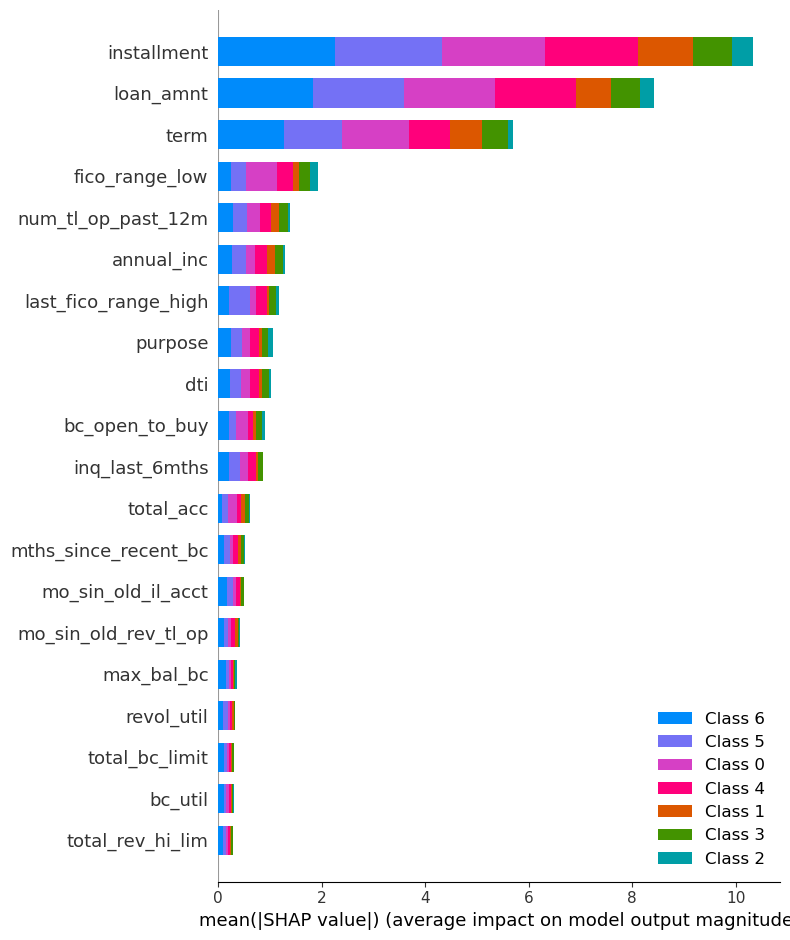

In [25]:
names = models.models['lgbm_grade_single'].pipeline["preprocess"].transform(X_val_single.sample(1000, seed=1)).columns
explainer_tree = shap.TreeExplainer(
    models.models['lgbm_grade_single'].pipeline["model"],
    data=models.models['lgbm_grade_single'].pipeline["preprocess"]
    .transform((X_val_single.sample(1000, seed=1)))
    .to_numpy(),
    # model_output="probability",
)

shap_values = explainer_tree.shap_values(
    models.models['lgbm_grade_single'].pipeline["preprocess"].transform(X_val_single.sample(1000, seed=1)).to_numpy()
)

shap.summary_plot(
    shap_values,
    models.models['lgbm_grade_single'].pipeline["preprocess"].transform(X_val_single.sample(10000, seed=1)).to_numpy(),
    feature_names=names,
    max_display=20,
)